In [1]:
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

# ignore the warning messge
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2021-09-27 05:22:10.388367: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Loading seen/open dataset and unseen/closed dataset

In [2]:
import os  
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Loading np array from images
def make_dataset(labels, dir_path, IMG_SIZE = 150):
    # initial an empty list X to store image of np.array()
    X = []

    # initial an empty list Z to store labels/names of cat individauls
    Z = []
    for label in labels:
        DIR = dir_path + label
        for img in tqdm(os.listdir(DIR)):
            path = os.path.join(DIR,img)
            # reading images
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            # resizing images to (150, 150, 3), 3 is the number of channels - RGB
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
            X.append(np.array(img))
            Z.append(str(label)) 
    ## Transform labels in Z to Y from class 0 to class 9, as 10 different cat individuals
    le=LabelEncoder()
    Y=le.fit_transform(Z)

    ## Transform and normalize X in the range of [0, 1]
    X=np.array(X)
    X=X/255.
    return X, Y

In [3]:
dir_path = '/kaggle/input/squirrel-monkey/Saimiri sciureus/'
IMG_SIZE = 150

# 44 monkey individuals, randomly select seen datset and unseen dataset
# make open set and unseen set 
def make_seen_unseen(num_classes, seen_ratio):
    arr = np.arange(num_classes)
    np.random.shuffle(arr)
    
    labels_seen = [str(i) for i in arr[:int(num_classes * seen_ratio)]]
    labels_unseen = [str(i) for i in arr[int(num_classes * seen_ratio):]]
    
    X_seen, Y_seen = make_dataset(labels_seen, dir_path)
    X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
    return X_seen, Y_seen, X_unseen, Y_unseen

# VGG 16 - Classification

In [4]:
def train_vgg16_model():
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_vgg_16 = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=len(Y_seen), activation='softmax')
    ])
    model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['acc']) 
    model_vgg_16.fit(x=x_train,
                     y=y_train,
                     epochs=EPOCHS,
                     batch_size=batch_size,
                     verbose=1)

    acc = round(model_vgg_16.evaluate(x_test, y_test)[1], 2)
    print('The accuracy on the Closed Dataset with VGG16 classification is {}'.format(acc))
    return model_vgg_16, acc

# Constractive Loss

In [5]:
# Helper Function 

# Create positive pairs and negative pairs
import random
def create_pairs(images, labels):
    numClasses = len(np.unique(Y_seen))
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive (0) or negative (1)
    np.random.seed(2021)
    pairImages = []
    pairLabels = []
    
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    idx = [np.where(labels == i)[0] for i in range(numClasses)]
    
    # loop voer all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current iteration
        currentImage = images[idxA]
        label = labels[idxA]
        
        # randomly pick on an image that belongs to the *same* class label
        posId = random.choice(idx[label])
        posImage = images[posId]
        
        # prepare a positive pair and update the images and labels
        pairImages.append([currentImage, posImage])
        pairLabels.append([0])
        
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negId = np.where(labels != label)[0]
        negIdx = random.choice(negId)
        negImage = images[negIdx]
        
        # prepare a negative pair of images and update out lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([1])
    
    return (np.array(pairImages), np.array(pairLabels))



# Function to calculate the distance between two images (Euclidean Distance used here)
import tensorflow.keras.backend as K
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
                       keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


# contrastive loss function
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean((1 - y) * squaredPreds + y * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss


# train the model using VGG 16 base model
def train_cl_model():
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                  input_shape = (imsize,imsize,3),
                  weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    

    model_cl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    
    imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
    featsA = model_cl(imgA)
    featsB = model_cl(imgB)
   
    distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
    model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
    model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(0.001))

    model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
               batch_size = batch_size, 
               epochs=EPOCHS, 
               verbose=1)
    return model_cl

In [6]:
# accuracy function - contrastive loss

import pylab as plot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def acc_cl(x_test, y_test, X_unseen, Y_unseen, k = 1, d_t = 1):
    embedding_train_cl = []
    for i in range(len(y_train)):
        embedding_train_cl.append(model_cl(x_train[i].reshape(1, imsize, imsize, 3))[0])
    embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

    knn_cl = KNeighborsClassifier(n_neighbors = k)
    knn_cl.fit(embedding_train_cl, y_train)
    
    #find the center point for each class in training set
    support_cl = []
    for i in range(len(np.unique(y_train))):
        support_cl.append(np.mean(embedding_train_cl[y_train==i], axis=0))
    support_cl = np.array(support_cl, dtype=float)
    
    pred = []
    temp_x = np.append(x_test, X_unseen, axis=0)
    temp_y = np.append(y_test, Y_unseen, axis=0)
    
    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)
    
    temp_x = temp_x[arr]
    temp_y = temp_y[arr]
    
    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(y_train))):
            embedding_test = model_cl(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_cl[j]
            #dist = tf.math.l2_normalize(embedding_test - embedding_anchor, axis=-1)
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        #a.append(dists)
        if min(dists) >= d_t:
            pred.append(10)
        else:
            pred.append(knn_cl.predict(embedding_test)[0])

    pred = np.array(pred)
    
    x_test_embedding = model_cl(x_test)
    acc_close = round(knn_cl.score(x_test_embedding, y_test), 2)
    acc_open = round(np.mean(pred == temp_y), 2)
    print('The accuracy on the Closed Dataset with contrastive loss is {}'.format(acc_close))
    print('The accuracy on the Open Dataset with contrastive lossis {}'.format(acc_open))
    
    return (acc_close, acc_open)

# Triplet Loss

In [7]:
from sklearn.neighbors import KNeighborsClassifier

## triplet loss using VGG 16 base model
imsize = 150
embeddingDim = 128
EPOCHS = 20
batch_size = 256

def train_tl_model():
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize, imsize, 3),
                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_tl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tfa.losses.TripletSemiHardLoss())

    model_tl.fit(x=x_train, y= y_train,
                 batch_size=batch_size,
                 epochs=EPOCHS, 
                 verbose=1)
    return model_tl

In [8]:
import pylab as plot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def acc_tl(x_test, y_test, X_unseen, Y_unseen, k = 1, d_t = 1):
    embedding_train_tl = []
    for i in range(len(y_train)):
        embedding_train_tl.append(model_tl(x_train[i].reshape(1, imsize, imsize, 3))[0])
        
    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, y_train)
    
    #find the center point for each class in training set
    support_tl = []
    for i in range(len(np.unique(y_train))):
        support_tl.append(np.mean(embedding_train_tl[y_train==i], axis=0))
        
    support_tl = np.array(support_tl, dtype=float)
    
    pred = []
    temp_x = np.append(x_test, X_unseen, axis=0)
    temp_y = np.append(y_test, Y_unseen, axis=0)
    
    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)
    
    temp_x = temp_x[arr]
    temp_y = temp_y[arr]
    
    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(y_train))):
            embedding_test = model_tl(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_tl[j]
            #dist = tf.math.l2_normalize(embedding_test - embedding_anchor, axis=-1)
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        #a.append(dists)
        if min(dists) >= d_t:
            pred.append(10)
        else:
            pred.append(knn_tl.predict(embedding_test)[0])

    pred = np.array(pred)
    
    x_test_embedding = model_tl(x_test)
    acc_close = round(knn_tl.score(x_test_embedding, y_test), 2)
    acc_open = round(np.mean(pred == temp_y), 2)
    print('The accuracy on the Closed Dataset with triplet loss is {}'.format(acc_close))
    print('The accuracy on the Open Dataset with triplet lossis {}'.format(acc_open))
    
    return (acc_close, acc_open)

# Configuration setting

In [9]:
imsize = 150
batch_size = 256
EPOCHS = 20
embeddingDim = 128

# 10 x 10 fold cross validation

In [10]:
from sklearn.model_selection import StratifiedKFold

acc_vgg16 = []
acc_cl_close = []
acc_cl_open = []
acc_tl_close = []
acc_tl_open = []

for _ in range(10):
    # randomly select 10% population as unseen
    X_seen, Y_seen, X_unseen, Y_unseen = make_seen_unseen(44, 0.9)
    skf = StratifiedKFold(n_splits=10, random_state=2021, shuffle=True)
    for train_index, test_index in skf.split(X_seen, Y_seen):
        x_train,x_test,y_train,y_test = X_seen[train_index], X_seen[test_index], Y_seen[train_index], Y_seen[test_index]
        model_vgg16, acc = train_vgg16_model()
        acc_vgg16.append(acc)

        (pairTrain, labelTrain) = create_pairs(x_train, y_train)
        model_cl = train_cl_model()
        (close_cl, open_cl) = acc_cl(x_test, y_test, X_unseen, Y_unseen)
        acc_cl_close.append(close_cl)
        acc_cl_open.append(open_cl)

        model_tl = train_tl_model()
        (close_tl, open_tl) = acc_tl(x_test, y_test, X_unseen, Y_unseen)
        acc_tl_close.append(close_tl)
        acc_tl_open.append(open_tl)

100%|██████████| 3/3 [00:00<00:00, 85.13it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
2021-09-27 05:22:19.461759: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-27 05:22:19.465212: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-27 05:22:19.504251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 05:22:19.504857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemo

58892288/58889256 [==============================] - 0s 0us/step


2021-09-27 05:22:22.262247: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-27 05:22:22.274788: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/20


2021-09-27 05:22:22.871903: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-27 05:22:23.640501: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-27 05:22:23.682111: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1/1 [==============================] - 14s 14s/step - loss: 5.4700 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 210ms/step - loss: 4.8927 - acc: 0.0941
Epoch 3/20
1/1 [==============================] - 0s 220ms/step - loss: 4.3851 - acc: 0.1238
Epoch 4/20
1/1 [==============================] - 0s 208ms/step - loss: 3.9475 - acc: 0.1238
Epoch 5/20
1/1 [==============================] - 0s 209ms/step - loss: 3.5720 - acc: 0.1931
Epoch 6/20
1/1 [==============================] - 0s 204ms/step - loss: 3.2477 - acc: 0.3267
Epoch 7/20
1/1 [==============================] - 0s 212ms/step - loss: 2.9653 - acc: 0.4356
Epoch 8/20
1/1 [==============================] - 0s 188ms/step - loss: 2.7230 - acc: 0.5099
Epoch 9/20
1/1 [==============================] - 0s 199ms/step - loss: 2.5095 - acc: 0.5495
Epoch 10/20
1/1 [==============================] - 0s 187ms/step - loss: 2.3137 - acc: 0.5842
Epoch 11/20
1/1 [==============================] - 0s 201ms/step - loss: 2.13

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.65
The accuracy on the Open Dataset with contrastive lossis 0.3
Epoch 1/20
1/1 [==============================] - 1s 793ms/step - loss: 0.9779
Epoch 2/20
1/1 [==============================] - 0s 190ms/step - loss: 0.9088
Epoch 3/20
1/1 [==============================] - 0s 193ms/step - loss: 0.7547
Epoch 4/20
1/1 [==============================] - 0s 201ms/step - loss: 0.6767
Epoch 5/20
1/1 [==============================] - 0s 199ms/step - loss: 0.5104
Epoch 6/20
1/1 [==============================] - 0s 192ms/step - loss: 0.4756
Epoch 7/20
1/1 [==============================] - 0s 194ms/step - loss: 0.3538
Epoch 8/20
1/1 [==============================] - 0s 199ms/step - loss: 0.2877
Epoch 9/20
1/1 [==============================] - 0s 194ms/step - loss: 0.2393
Epoch 10/20
1/1 [==============================] - 0s 204ms/step - loss: 0.1898
Epoch 11/20
1/1 [==============================] - 0s 193ms/step - loss: 0.1591
Epo

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.78
The accuracy on the Open Dataset with triplet lossis 0.36
Epoch 1/20
1/1 [==============================] - 1s 701ms/step - loss: 5.7205 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 189ms/step - loss: 5.1261 - acc: 0.0198
Epoch 3/20
1/1 [==============================] - 0s 191ms/step - loss: 4.5930 - acc: 0.2079
Epoch 4/20
1/1 [==============================] - 0s 205ms/step - loss: 4.1298 - acc: 0.2624
Epoch 5/20
1/1 [==============================] - 0s 187ms/step - loss: 3.7417 - acc: 0.2772
Epoch 6/20
1/1 [==============================] - 0s 205ms/step - loss: 3.4191 - acc: 0.3020
Epoch 7/20
1/1 [==============================] - 0s 190ms/step - loss: 3.1381 - acc: 0.3762
Epoch 8/20
1/1 [==============================] - 0s 189ms/step - loss: 2.8842 - acc: 0.4356
Epoch 9/20
1/1 [==============================] - 0s 196ms/step - loss: 2.6534 - acc: 0.5396
Epoch 10/20
1/1 [=======================

100%|██████████| 5/5 [00:00<00:00, 188.99it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 5.6978 - acc: 0.0254
Epoch 2/20
1/1 [==============================] - 0s 204ms/step - loss: 5.1104 - acc: 0.0508
Epoch 3/20
1/1 [==============================] - 0s 201ms/step - loss: 4.5823 - acc: 0.1218
Epoch 4/20
1/1 [==============================] - 0s 203ms/step - loss: 4.1160 - acc: 0.2234
Epoch 5/20
1/1 [==============================] - 0s 205ms/step - loss: 3.7148 - acc: 0.3350
Epoch 6/20
1/1 [==============================] - 0s 209ms/step - loss: 3.3761 - acc: 0.3706
Epoch 7/20
1/1 [==============================] - 0s 195ms/step - loss: 3.0895 - acc: 0.4315
Epoch 8/20
1/1 [==============================] - 0s 205ms/step - loss: 2.8409 - acc: 0.4873
Epoch 9/20
1/1 [==============================] - 0s 211ms/step - loss: 2.6162 - acc: 0.4975
Epoch 10/20
1/1 [==============================] - 0s 192ms/step - loss: 2.4091 - acc: 0.5025
Epoch 11/20
1/1 [==============================] - 0s 206ms/step - loss:

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.73
The accuracy on the Open Dataset with contrastive lossis 0.31
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9821
Epoch 2/20
1/1 [==============================] - 0s 213ms/step - loss: 0.8973
Epoch 3/20
1/1 [==============================] - 0s 208ms/step - loss: 0.7888
Epoch 4/20
1/1 [==============================] - 0s 208ms/step - loss: 0.6603
Epoch 5/20
1/1 [==============================] - 0s 193ms/step - loss: 0.5514
Epoch 6/20
1/1 [==============================] - 0s 192ms/step - loss: 0.4752
Epoch 7/20
1/1 [==============================] - 0s 189ms/step - loss: 0.3968
Epoch 8/20
1/1 [==============================] - 0s 196ms/step - loss: 0.3255
Epoch 9/20
1/1 [==============================] - 0s 207ms/step - loss: 0.2678
Epoch 10/20
1/1 [==============================] - 0s 209ms/step - loss: 0.2445
Epoch 11/20
1/1 [==============================] - 0s 204ms/step - loss: 0.1834
Epoch

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.59
The accuracy on the Open Dataset with triplet lossis 0.27
Epoch 1/20
1/1 [==============================] - 1s 696ms/step - loss: 5.3902 - acc: 0.0152
Epoch 2/20
1/1 [==============================] - 0s 190ms/step - loss: 4.8293 - acc: 0.0914
Epoch 3/20
1/1 [==============================] - 0s 205ms/step - loss: 4.3333 - acc: 0.1523
Epoch 4/20
1/1 [==============================] - 0s 190ms/step - loss: 3.9061 - acc: 0.1371
Epoch 5/20
1/1 [==============================] - 0s 186ms/step - loss: 3.5397 - acc: 0.2183
Epoch 6/20
1/1 [==============================] - 0s 191ms/step - loss: 3.2243 - acc: 0.3401
Epoch 7/20
1/1 [==============================] - 0s 208ms/step - loss: 2.9532 - acc: 0.4162
Epoch 8/20
1/1 [==============================] - 0s 198ms/step - loss: 2.7188 - acc: 0.4569
Epoch 9/20
1/1 [==============================] - 0s 201ms/step - loss: 2.5072 - acc: 0.4822
Epoch 10/20
1/1 [===========================

100%|██████████| 5/5 [00:00<00:00, 136.88it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 1s 704ms/step - loss: 5.4197 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 194ms/step - loss: 4.8290 - acc: 0.0660
Epoch 3/20
1/1 [==============================] - 0s 205ms/step - loss: 4.3064 - acc: 0.2081
Epoch 4/20
1/1 [==============================] - 0s 190ms/step - loss: 3.8548 - acc: 0.2944
Epoch 5/20
1/1 [==============================] - 0s 204ms/step - loss: 3.4784 - acc: 0.3249
Epoch 6/20
1/1 [==============================] - 0s 189ms/step - loss: 3.1707 - acc: 0.3401
Epoch 7/20
1/1 [==============================] - 0s 186ms/step - loss: 2.9125 - acc: 0.4010
Epoch 8/20
1/1 [==============================] - 0s 204ms/step - loss: 2.6805 - acc: 0.4518
Epoch 9/20
1/1 [==============================] - 0s 206ms/step - loss: 2.4651 - acc: 0.5127
Epoch 10/20
1/1 [==============================] - 0s 208ms/step - loss: 2.2649 - acc: 0.5939
Epoch 11/20
1/1 [==============================] - 0s 205ms/step 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.64
The accuracy on the Open Dataset with contrastive lossis 0.25
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9798
Epoch 2/20
1/1 [==============================] - 0s 206ms/step - loss: 0.9017
Epoch 3/20
1/1 [==============================] - 0s 215ms/step - loss: 0.7900
Epoch 4/20
1/1 [==============================] - 0s 215ms/step - loss: 0.6454
Epoch 5/20
1/1 [==============================] - 0s 214ms/step - loss: 0.5355
Epoch 6/20
1/1 [==============================] - 0s 216ms/step - loss: 0.4263
Epoch 7/20
1/1 [==============================] - 0s 211ms/step - loss: 0.3781
Epoch 8/20
1/1 [==============================] - 0s 207ms/step - loss: 0.3108
Epoch 9/20
1/1 [==============================] - 0s 209ms/step - loss: 0.2408
Epoch 10/20
1/1 [==============================] - 0s 209ms/step - loss: 0.2103
Epoch 11/20
1/1 [==============================] - 0s 206ms/step - loss: 0.1738
Epoch

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.68
The accuracy on the Open Dataset with triplet lossis 0.31
Epoch 1/20
1/1 [==============================] - 1s 700ms/step - loss: 5.6623 - acc: 0.0305
Epoch 2/20
1/1 [==============================] - 0s 187ms/step - loss: 5.0913 - acc: 0.0508
Epoch 3/20
1/1 [==============================] - 0s 203ms/step - loss: 4.5746 - acc: 0.0812
Epoch 4/20
1/1 [==============================] - 0s 204ms/step - loss: 4.1125 - acc: 0.1827
Epoch 5/20
1/1 [==============================] - 0s 193ms/step - loss: 3.7110 - acc: 0.2944
Epoch 6/20
1/1 [==============================] - 0s 196ms/step - loss: 3.3664 - acc: 0.3147
Epoch 7/20
1/1 [==============================] - 0s 197ms/step - loss: 3.0648 - acc: 0.3655
Epoch 8/20
1/1 [==============================] - 0s 206ms/step - loss: 2.7964 - acc: 0.4569
Epoch 9/20
1/1 [==============================] - 0s 207ms/step - loss: 2.5608 - acc: 0.4822
Epoch 10/20
1/1 [===========================

100%|██████████| 5/5 [00:00<00:00, 188.87it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 1s 736ms/step - loss: 5.6596 - acc: 0.0102
Epoch 2/20
1/1 [==============================] - 0s 205ms/step - loss: 5.0437 - acc: 0.0102
Epoch 3/20
1/1 [==============================] - 0s 193ms/step - loss: 4.4835 - acc: 0.1777
Epoch 4/20
1/1 [==============================] - 0s 185ms/step - loss: 3.9921 - acc: 0.2640
Epoch 5/20
1/1 [==============================] - 0s 187ms/step - loss: 3.5786 - acc: 0.3299
Epoch 6/20
1/1 [==============================] - 0s 215ms/step - loss: 3.2351 - acc: 0.3807
Epoch 7/20
1/1 [==============================] - 0s 206ms/step - loss: 2.9416 - acc: 0.4772
Epoch 8/20
1/1 [==============================] - 0s 185ms/step - loss: 2.6850 - acc: 0.5330
Epoch 9/20
1/1 [==============================] - 0s 206ms/step - loss: 2.4641 - acc: 0.5939
Epoch 10/20
1/1 [==============================] - 0s 194ms/step - loss: 2.2735 - acc: 0.5939
Epoch 11/20
1/1 [==============================] - 0s 209ms/step - lo

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.77
The accuracy on the Open Dataset with contrastive lossis 0.31
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9733
Epoch 2/20
1/1 [==============================] - 0s 204ms/step - loss: 0.9232
Epoch 3/20
1/1 [==============================] - 0s 223ms/step - loss: 0.7566
Epoch 4/20
1/1 [==============================] - 0s 210ms/step - loss: 0.6696
Epoch 5/20
1/1 [==============================] - 0s 225ms/step - loss: 0.5423
Epoch 6/20
1/1 [==============================] - 0s 191ms/step - loss: 0.4364
Epoch 7/20
1/1 [==============================] - 0s 229ms/step - loss: 0.3978
Epoch 8/20
1/1 [==============================] - 0s 208ms/step - loss: 0.2959
Epoch 9/20
1/1 [==============================] - 0s 227ms/step - loss: 0.2424
Epoch 10/20
1/1 [==============================] - 0s 204ms/step - loss: 0.2038
Epoch 11/20
1/1 [==============================] - 0s 210ms/step - loss: 0.1608
Epoch

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.68
The accuracy on the Open Dataset with triplet lossis 0.31
Epoch 1/20
1/1 [==============================] - 1s 717ms/step - loss: 5.5443 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 212ms/step - loss: 4.9718 - acc: 0.0711
Epoch 3/20
1/1 [==============================] - 0s 191ms/step - loss: 4.4655 - acc: 0.1523
Epoch 4/20
1/1 [==============================] - 0s 193ms/step - loss: 4.0254 - acc: 0.2437
Epoch 5/20
1/1 [==============================] - 0s 205ms/step - loss: 3.6527 - acc: 0.2538
Epoch 6/20
1/1 [==============================] - 0s 207ms/step - loss: 3.3323 - acc: 0.2690
Epoch 7/20
1/1 [==============================] - 0s 186ms/step - loss: 3.0467 - acc: 0.3401
Epoch 8/20
1/1 [==============================] - 0s 210ms/step - loss: 2.7925 - acc: 0.4670
Epoch 9/20
1/1 [==============================] - 0s 207ms/step - loss: 2.5686 - acc: 0.5431
Epoch 10/20
1/1 [=======================

100%|██████████| 5/5 [00:00<00:00, 193.50it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 1s 684ms/step - loss: 5.5567 - acc: 0.0051
Epoch 2/20
1/1 [==============================] - 0s 202ms/step - loss: 4.9988 - acc: 0.0711
Epoch 3/20
1/1 [==============================] - 0s 206ms/step - loss: 4.5037 - acc: 0.1117
Epoch 4/20
1/1 [==============================] - 0s 204ms/step - loss: 4.0679 - acc: 0.1472
Epoch 5/20
1/1 [==============================] - 0s 185ms/step - loss: 3.6857 - acc: 0.2487
Epoch 6/20
1/1 [==============================] - 0s 206ms/step - loss: 3.3569 - acc: 0.3807
Epoch 7/20
1/1 [==============================] - 0s 186ms/step - loss: 3.0735 - acc: 0.4213
Epoch 8/20
1/1 [==============================] - 0s 186ms/step - loss: 2.8211 - acc: 0.4619
Epoch 9/20
1/1 [==============================] - 0s 200ms/step - loss: 2.5888 - acc: 0.5076
Epoch 10/20
1/1 [==============================] - 0s 205ms/step - loss: 2.3746 - acc: 0.5381
Epoch 11/20
1/1 [==============================] - 0s 202ms/step - lo

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.55
The accuracy on the Open Dataset with contrastive lossis 0.22
Epoch 1/20
1/1 [==============================] - 1s 786ms/step - loss: 0.9778
Epoch 2/20
1/1 [==============================] - 0s 208ms/step - loss: 0.9111
Epoch 3/20
1/1 [==============================] - 0s 198ms/step - loss: 0.7386
Epoch 4/20
1/1 [==============================] - 0s 208ms/step - loss: 0.7039
Epoch 5/20
1/1 [==============================] - 0s 188ms/step - loss: 0.5624
Epoch 6/20
1/1 [==============================] - 0s 189ms/step - loss: 0.4518
Epoch 7/20
1/1 [==============================] - 0s 197ms/step - loss: 0.3726
Epoch 8/20
1/1 [==============================] - 0s 205ms/step - loss: 0.3158
Epoch 9/20
1/1 [==============================] - 0s 192ms/step - loss: 0.2633
Epoch 10/20
1/1 [==============================] - 0s 209ms/step - loss: 0.1991
Epoch 11/20
1/1 [==============================] - 0s 208ms/step - loss: 0.1882
Ep

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.68
The accuracy on the Open Dataset with triplet lossis 0.33
Epoch 1/20
1/1 [==============================] - 1s 690ms/step - loss: 5.7212 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 205ms/step - loss: 5.0933 - acc: 0.0102
Epoch 3/20
1/1 [==============================] - 0s 204ms/step - loss: 4.5330 - acc: 0.1269
Epoch 4/20
1/1 [==============================] - 0s 185ms/step - loss: 4.0480 - acc: 0.2690
Epoch 5/20
1/1 [==============================] - 0s 201ms/step - loss: 3.6455 - acc: 0.3249
Epoch 6/20
1/1 [==============================] - 0s 185ms/step - loss: 3.3198 - acc: 0.3503
Epoch 7/20
1/1 [==============================] - 0s 202ms/step - loss: 3.0525 - acc: 0.3706
Epoch 8/20
1/1 [==============================] - 0s 201ms/step - loss: 2.8222 - acc: 0.4365
Epoch 9/20
1/1 [==============================] - 0s 185ms/step - loss: 2.6179 - acc: 0.4924
Epoch 10/20
1/1 [=======================

100%|██████████| 5/5 [00:00<00:00, 72.74it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 1s 723ms/step - loss: 5.8595 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 208ms/step - loss: 5.2548 - acc: 0.0102
Epoch 3/20
1/1 [==============================] - 0s 206ms/step - loss: 4.7005 - acc: 0.1523
Epoch 4/20
1/1 [==============================] - 0s 193ms/step - loss: 4.2091 - acc: 0.2081
Epoch 5/20
1/1 [==============================] - 0s 206ms/step - loss: 3.7887 - acc: 0.2437
Epoch 6/20
1/1 [==============================] - 0s 206ms/step - loss: 3.4373 - acc: 0.3046
Epoch 7/20
1/1 [==============================] - 0s 209ms/step - loss: 3.1395 - acc: 0.3959
Epoch 8/20
1/1 [==============================] - 0s 203ms/step - loss: 2.8768 - acc: 0.4467
Epoch 9/20
1/1 [==============================] - 0s 197ms/step - loss: 2.6413 - acc: 0.5076
Epoch 10/20
1/1 [==============================] - 0s 190ms/step - loss: 2.4303 - acc: 0.5381
Epoch 11/20
1/1 [==============================] - 0s 208ms/step 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.68
The accuracy on the Open Dataset with contrastive lossis 0.27
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.9799
Epoch 2/20
1/1 [==============================] - 0s 212ms/step - loss: 0.9103
Epoch 3/20
1/1 [==============================] - 0s 215ms/step - loss: 0.7612
Epoch 4/20
1/1 [==============================] - 0s 216ms/step - loss: 0.7076
Epoch 5/20
1/1 [==============================] - 0s 213ms/step - loss: 0.5502
Epoch 6/20
1/1 [==============================] - 0s 214ms/step - loss: 0.4586
Epoch 7/20
1/1 [==============================] - 0s 213ms/step - loss: 0.3771
Epoch 8/20
1/1 [==============================] - 0s 209ms/step - loss: 0.3084
Epoch 9/20
1/1 [==============================] - 0s 212ms/step - loss: 0.2685
Epoch 10/20
1/1 [==============================] - 0s 221ms/step - loss: 0.2120
Epoch 11/20
1/1 [==============================] - 0s 226ms/step - loss: 0.1899
Epoch

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.59
The accuracy on the Open Dataset with triplet lossis 0.27
Epoch 1/20
1/1 [==============================] - 1s 700ms/step - loss: 5.6073 - acc: 0.0051
Epoch 2/20
1/1 [==============================] - 0s 198ms/step - loss: 5.0212 - acc: 0.0355
Epoch 3/20
1/1 [==============================] - 0s 194ms/step - loss: 4.4961 - acc: 0.1371
Epoch 4/20
1/1 [==============================] - 0s 206ms/step - loss: 4.0344 - acc: 0.2690
Epoch 5/20
1/1 [==============================] - 0s 191ms/step - loss: 3.6386 - acc: 0.2893
Epoch 6/20
1/1 [==============================] - 0s 192ms/step - loss: 3.3026 - acc: 0.3046
Epoch 7/20
1/1 [==============================] - 0s 228ms/step - loss: 3.0169 - acc: 0.3503
Epoch 8/20
1/1 [==============================] - 0s 213ms/step - loss: 2.7674 - acc: 0.4365
Epoch 9/20
1/1 [==============================] - 0s 217ms/step - loss: 2.5447 - acc: 0.5076
Epoch 10/20
1/1 [===========================

100%|██████████| 5/5 [00:00<00:00, 112.16it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 5.6188 - acc: 0.0051
Epoch 2/20
1/1 [==============================] - 0s 212ms/step - loss: 5.0218 - acc: 0.0102
Epoch 3/20
1/1 [==============================] - 0s 213ms/step - loss: 4.4865 - acc: 0.2183
Epoch 4/20
1/1 [==============================] - 0s 205ms/step - loss: 4.0218 - acc: 0.2741
Epoch 5/20
1/1 [==============================] - 0s 190ms/step - loss: 3.6258 - acc: 0.2893
Epoch 6/20
1/1 [==============================] - 0s 187ms/step - loss: 3.2902 - acc: 0.3401
Epoch 7/20
1/1 [==============================] - 0s 207ms/step - loss: 3.0006 - acc: 0.3807
Epoch 8/20
1/1 [==============================] - 0s 188ms/step - loss: 2.7438 - acc: 0.4619
Epoch 9/20
1/1 [==============================] - 0s 206ms/step - loss: 2.5132 - acc: 0.5482
Epoch 10/20
1/1 [==============================] - 0s 206ms/step - loss: 2.3078 - acc: 0.5939
Epoch 11/20
1/1 [==============================] - 0s 194ms/step - loss:

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.59
The accuracy on the Open Dataset with contrastive lossis 0.24
Epoch 1/20
1/1 [==============================] - 1s 781ms/step - loss: 0.9777
Epoch 2/20
1/1 [==============================] - 0s 186ms/step - loss: 0.8993
Epoch 3/20
1/1 [==============================] - 0s 190ms/step - loss: 0.7672
Epoch 4/20
1/1 [==============================] - 0s 196ms/step - loss: 0.6477
Epoch 5/20
1/1 [==============================] - 0s 192ms/step - loss: 0.5887
Epoch 6/20
1/1 [==============================] - 0s 211ms/step - loss: 0.4441
Epoch 7/20
1/1 [==============================] - 0s 215ms/step - loss: 0.4116
Epoch 8/20
1/1 [==============================] - 0s 198ms/step - loss: 0.3477
Epoch 9/20
1/1 [==============================] - 0s 195ms/step - loss: 0.2714
Epoch 10/20
1/1 [==============================] - 0s 209ms/step - loss: 0.2260
Epoch 11/20
1/1 [==============================] - 0s 190ms/step - loss: 0.1942
Ep

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.73
The accuracy on the Open Dataset with triplet lossis 0.33
Epoch 1/20
1/1 [==============================] - 1s 697ms/step - loss: 5.7247 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 203ms/step - loss: 5.1070 - acc: 0.0254
Epoch 3/20
1/1 [==============================] - 0s 204ms/step - loss: 4.5661 - acc: 0.1320
Epoch 4/20
1/1 [==============================] - 0s 204ms/step - loss: 4.1068 - acc: 0.1523
Epoch 5/20
1/1 [==============================] - 0s 204ms/step - loss: 3.7248 - acc: 0.1777
Epoch 6/20
1/1 [==============================] - 0s 193ms/step - loss: 3.4007 - acc: 0.2640
Epoch 7/20
1/1 [==============================] - 0s 207ms/step - loss: 3.1164 - acc: 0.3452
Epoch 8/20
1/1 [==============================] - 0s 204ms/step - loss: 2.8606 - acc: 0.4416
Epoch 9/20
1/1 [==============================] - 0s 206ms/step - loss: 2.6268 - acc: 0.4975
Epoch 10/20
1/1 [=======================

100%|██████████| 5/5 [00:00<00:00, 194.72it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 1s 712ms/step - loss: 5.5925 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 192ms/step - loss: 4.9911 - acc: 0.0406
Epoch 3/20
1/1 [==============================] - 0s 196ms/step - loss: 4.4566 - acc: 0.2234
Epoch 4/20
1/1 [==============================] - 0s 210ms/step - loss: 3.9950 - acc: 0.2741
Epoch 5/20
1/1 [==============================] - 0s 214ms/step - loss: 3.6077 - acc: 0.3198
Epoch 6/20
1/1 [==============================] - 0s 208ms/step - loss: 3.2849 - acc: 0.3604
Epoch 7/20
1/1 [==============================] - 0s 209ms/step - loss: 3.0101 - acc: 0.4061
Epoch 8/20
1/1 [==============================] - 0s 186ms/step - loss: 2.7663 - acc: 0.4619
Epoch 9/20
1/1 [==============================] - 0s 207ms/step - loss: 2.5446 - acc: 0.4975
Epoch 10/20
1/1 [==============================] - 0s 205ms/step - loss: 2.3387 - acc: 0.5431
Epoch 11/20
1/1 [==============================] - 0s 187ms/step 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.64
The accuracy on the Open Dataset with contrastive lossis 0.25
Epoch 1/20
1/1 [==============================] - 1s 770ms/step - loss: 0.9799
Epoch 2/20
1/1 [==============================] - 0s 209ms/step - loss: 0.9096
Epoch 3/20
1/1 [==============================] - 0s 194ms/step - loss: 0.7598
Epoch 4/20
1/1 [==============================] - 0s 212ms/step - loss: 0.7028
Epoch 5/20
1/1 [==============================] - 0s 202ms/step - loss: 0.5722
Epoch 6/20
1/1 [==============================] - 0s 212ms/step - loss: 0.4375
Epoch 7/20
1/1 [==============================] - 0s 215ms/step - loss: 0.4215
Epoch 8/20
1/1 [==============================] - 0s 214ms/step - loss: 0.3278
Epoch 9/20
1/1 [==============================] - 0s 208ms/step - loss: 0.2711
Epoch 10/20
1/1 [==============================] - 0s 206ms/step - loss: 0.2355
Epoch 11/20
1/1 [==============================] - 0s 188ms/step - loss: 0.1895
Ep

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.59
The accuracy on the Open Dataset with triplet lossis 0.27
Epoch 1/20
1/1 [==============================] - 1s 988ms/step - loss: 5.5286 - acc: 0.0051
Epoch 2/20
1/1 [==============================] - 0s 203ms/step - loss: 4.9615 - acc: 0.0711
Epoch 3/20
1/1 [==============================] - 0s 225ms/step - loss: 4.4517 - acc: 0.1269
Epoch 4/20
1/1 [==============================] - 0s 218ms/step - loss: 4.0043 - acc: 0.1675
Epoch 5/20
1/1 [==============================] - 0s 224ms/step - loss: 3.6209 - acc: 0.2487
Epoch 6/20
1/1 [==============================] - 0s 208ms/step - loss: 3.2969 - acc: 0.3401
Epoch 7/20
1/1 [==============================] - 0s 204ms/step - loss: 3.0211 - acc: 0.4061
Epoch 8/20
1/1 [==============================] - 0s 211ms/step - loss: 2.7803 - acc: 0.4721
Epoch 9/20
1/1 [==============================] - 0s 211ms/step - loss: 2.5629 - acc: 0.5178
Epoch 10/20
1/1 [===========================

100%|██████████| 5/5 [00:00<00:00, 117.57it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 1s 998ms/step - loss: 5.8332 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 227ms/step - loss: 5.2088 - acc: 0.0152
Epoch 3/20
1/1 [==============================] - 0s 190ms/step - loss: 4.6492 - acc: 0.1168
Epoch 4/20
1/1 [==============================] - 0s 220ms/step - loss: 4.1594 - acc: 0.1980
Epoch 5/20
1/1 [==============================] - 0s 205ms/step - loss: 3.7398 - acc: 0.2843
Epoch 6/20
1/1 [==============================] - 0s 191ms/step - loss: 3.3862 - acc: 0.3198
Epoch 7/20
1/1 [==============================] - 0s 226ms/step - loss: 3.0855 - acc: 0.3655
Epoch 8/20
1/1 [==============================] - 0s 218ms/step - loss: 2.8213 - acc: 0.4467
Epoch 9/20
1/1 [==============================] - 0s 203ms/step - loss: 2.5836 - acc: 0.4924
Epoch 10/20
1/1 [==============================] - 0s 225ms/step - loss: 2.3707 - acc: 0.5533
Epoch 11/20
1/1 [==============================] - 0s 218ms/step 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.73
The accuracy on the Open Dataset with contrastive lossis 0.29
Epoch 1/20
1/1 [==============================] - 1s 778ms/step - loss: 0.9794
Epoch 2/20
1/1 [==============================] - 0s 210ms/step - loss: 0.9061
Epoch 3/20
1/1 [==============================] - 0s 195ms/step - loss: 0.7395
Epoch 4/20
1/1 [==============================] - 0s 200ms/step - loss: 0.6957
Epoch 5/20
1/1 [==============================] - 0s 209ms/step - loss: 0.5742
Epoch 6/20
1/1 [==============================] - 0s 189ms/step - loss: 0.4439
Epoch 7/20
1/1 [==============================] - 0s 190ms/step - loss: 0.4014
Epoch 8/20
1/1 [==============================] - 0s 197ms/step - loss: 0.3341
Epoch 9/20
1/1 [==============================] - 0s 209ms/step - loss: 0.2547
Epoch 10/20
1/1 [==============================] - 0s 211ms/step - loss: 0.2297
Epoch 11/20
1/1 [==============================] - 0s 205ms/step - loss: 0.1757
Ep

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.73
The accuracy on the Open Dataset with triplet lossis 0.33
Epoch 1/20
1/1 [==============================] - 1s 863ms/step - loss: 5.7295 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 225ms/step - loss: 5.1496 - acc: 0.0152
Epoch 3/20
1/1 [==============================] - 0s 225ms/step - loss: 4.6265 - acc: 0.1015
Epoch 4/20
1/1 [==============================] - 0s 225ms/step - loss: 4.1613 - acc: 0.2132
Epoch 5/20
1/1 [==============================] - 0s 224ms/step - loss: 3.7619 - acc: 0.2640
Epoch 6/20
1/1 [==============================] - 0s 227ms/step - loss: 3.4304 - acc: 0.3096
Epoch 7/20
1/1 [==============================] - 0s 219ms/step - loss: 3.1553 - acc: 0.3401
Epoch 8/20
1/1 [==============================] - 0s 214ms/step - loss: 2.9146 - acc: 0.4264
Epoch 9/20
1/1 [==============================] - 0s 221ms/step - loss: 2.6960 - acc: 0.5127
Epoch 10/20
1/1 [=======================

100%|██████████| 5/5 [00:00<00:00, 117.15it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
1/1 [==============================] - 1s 972ms/step - loss: 5.6361 - acc: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 249ms/step - loss: 5.0185 - acc: 0.0406
Epoch 3/20
1/1 [==============================] - 0s 252ms/step - loss: 4.4745 - acc: 0.2234
Epoch 4/20
1/1 [==============================] - 0s 203ms/step - loss: 4.0148 - acc: 0.2183
Epoch 5/20
1/1 [==============================] - 0s 226ms/step - loss: 3.6380 - acc: 0.2284
Epoch 6/20
1/1 [==============================] - 0s 237ms/step - loss: 3.3202 - acc: 0.2690
Epoch 7/20
1/1 [==============================] - 0s 190ms/step - loss: 3.0336 - acc: 0.3655
Epoch 8/20
1/1 [==============================] - 0s 225ms/step - loss: 2.7756 - acc: 0.4569
Epoch 9/20
1/1 [==============================] - 0s 227ms/step - loss: 2.5473 - acc: 0.5431
Epoch 10/20
1/1 [==============================] - 0s 228ms/step - loss: 2.3436 - acc: 0.5584
Epoch 11/20
1/1 [==============================] - 0s 227ms/step 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with contrastive loss is 0.73
The accuracy on the Open Dataset with contrastive lossis 0.35
Epoch 1/20
1/1 [==============================] - 1s 798ms/step - loss: 0.9789
Epoch 2/20
1/1 [==============================] - 0s 192ms/step - loss: 0.9256
Epoch 3/20
1/1 [==============================] - 0s 194ms/step - loss: 0.7632
Epoch 4/20
1/1 [==============================] - 0s 190ms/step - loss: 0.7103
Epoch 5/20
1/1 [==============================] - 0s 198ms/step - loss: 0.5499
Epoch 6/20
1/1 [==============================] - 0s 208ms/step - loss: 0.4808
Epoch 7/20
1/1 [==============================] - 0s 191ms/step - loss: 0.3871
Epoch 8/20
1/1 [==============================] - 0s 197ms/step - loss: 0.3209
Epoch 9/20
1/1 [==============================] - 0s 190ms/step - loss: 0.2798
Epoch 10/20
1/1 [==============================] - 0s 211ms/step - loss: 0.2102
Epoch 11/20
1/1 [==============================] - 0s 208ms/step - loss: 0.1730
Ep

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


The accuracy on the Closed Dataset with triplet loss is 0.73
The accuracy on the Open Dataset with triplet lossis 0.31
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 5.5386 - acc: 0.0102
Epoch 2/20
1/1 [==============================] - 0s 205ms/step - loss: 4.9600 - acc: 0.0457
Epoch 3/20
1/1 [==============================] - 0s 195ms/step - loss: 4.4464 - acc: 0.1675
Epoch 4/20
1/1 [==============================] - 0s 192ms/step - loss: 4.0032 - acc: 0.2132
Epoch 5/20
1/1 [==============================] - 0s 195ms/step - loss: 3.6306 - acc: 0.2487
Epoch 6/20
1/1 [==============================] - 0s 210ms/step - loss: 3.3182 - acc: 0.2893
Epoch 7/20
1/1 [==============================] - 0s 228ms/step - loss: 3.0469 - acc: 0.3604
Epoch 8/20
1/1 [==============================] - 0s 215ms/step - loss: 2.8022 - acc: 0.4569
Epoch 9/20
1/1 [==============================] - 0s 211ms/step - loss: 2.5795 - acc: 0.5381
Epoch 10/20
1/1 [==============================

# Average and standard devation of accuracies from 10 x 10 folds CV 

In [11]:
import pandas as pd
acc_closed = pd.DataFrame({'vgg16': acc_vgg16, 'constrastive_loss': acc_cl_close, 'triplet_loss':acc_tl_close})
acc_closed.agg(['mean', 'std'])

,vgg16,constrastive_loss,triplet_loss
mean,0.606700,0.698900,0.755400
std,0.086784,0.082351,0.071822


In [12]:
acc_open = pd.DataFrame({'contrastive_loss': acc_cl_open, 'triplet_loss':acc_tl_open})
acc_open.agg(['mean', 'std'])

,contrastive_loss,triplet_loss
mean,0.29320,0.336700
std,0.03982,0.032444


# Plot of accuracy of VGG16 classification, contrastive loss and triplet loss on Closed data and Open dataset

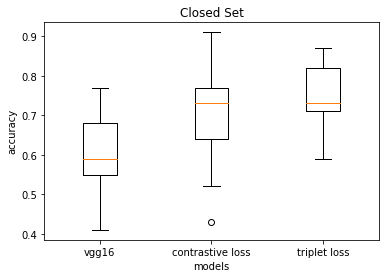

In [13]:
plt.boxplot([acc_vgg16, acc_cl_close, acc_tl_close], labels=['vgg16', 'contrastive loss', 'triplet loss'])
plt.xlabel('models')
plt.ylabel('accuracy')
plt.title('Closed Set')
plt.show()

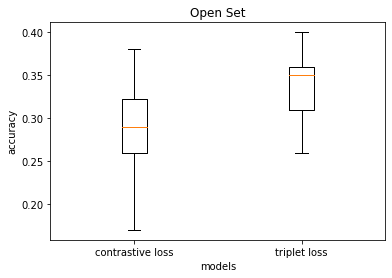

In [14]:
plt.boxplot([acc_cl_open, acc_tl_open], labels=['contrastive loss', 'triplet loss'])
plt.xlabel('models')
plt.ylabel('accuracy')
plt.title('Open Set')
plt.show()

In [15]:
!pip install autorank

# Closed Set

In [16]:
from autorank import autorank, plot_stats, create_report

results_closed = autorank(acc_closed, alpha = 0.05, verbose=False)
print(results_closed)

RankResult(rankdf=
                   meanrank  median       mad ci_lower ci_upper effect_size  \
triplet_loss           1.25    0.73   0.07413     0.73     0.82         0.0   
constrastive_loss      1.92    0.73   0.07413     0.68     0.73         0.0   
vgg16                  2.83    0.59  0.088956     0.55     0.64    1.709835   

                    magnitude  
triplet_loss       negligible  
constrastive_loss  negligible  
vgg16                   large  
pvalue=5.4516992905047015e-31
cd=0.3314497968385934
omnibus=friedman
posthoc=nemenyi
all_normal=False
pvals_shapiro=[0.014988318085670471, 0.005594328511506319, 0.00022288358013611287]
homoscedastic=True
pval_homogeneity=0.2604611479693953
homogeneity_test=levene
alpha=0.05
alpha_normality=0.016666666666666666
num_samples=100
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=akinshin_gamma)


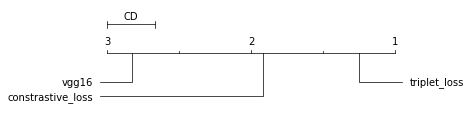

In [17]:
plot_stats(results_closed)
plt.show()

In [18]:
create_report(results_closed)

The statistical analysis was conducted for 3 populations with 100 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations triplet_loss (p=0.015), constrastive_loss (p=0.006), and vgg16 (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=0.331 of the Nemenyi test.
We reject the null hypothesis (p=0

# Open Set

In [19]:
results_open = autorank(acc_open, alpha = 0.05, verbose=False)
print(results_open)

RankResult(rankdf=
                  meanrank  median       mad ci_lower ci_upper effect_size  \
triplet_loss          1.14    0.35  0.029652     0.33     0.36         0.0   
contrastive_loss      1.86    0.29  0.044478     0.27     0.31    1.587342   

                   magnitude  
triplet_loss      negligible  
contrastive_loss       large  
pvalue=4.0688932510312003e-14
cd=None
omnibus=wilcoxon
posthoc=None
all_normal=False
pvals_shapiro=[0.037192996591329575, 8.439626981271431e-05]
homoscedastic=False
pval_homogeneity=0.039660115795906586
homogeneity_test=levene
alpha=0.05
alpha_normality=0.025
num_samples=100
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=akinshin_gamma)


In [20]:
plot_stats(results_open)
plt.show()

/opt/conda/lib/python3.7/site-packages/autorank/autorank.py:331: UserWarning: No plot to visualize statistics for Wilcoxon test available. Doing nothing.
  warnings.warn('No plot to visualize statistics for Wilcoxon test available. Doing nothing.')


In [21]:
create_report(results_open)

The statistical analysis was conducted for 2 populations with 100 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population contrastive_loss (p=0.000). Therefore, we assume that not all populations are normal.
No check for homogeneity was required because we only have two populations.
Because we have only two populations and one of them is not normal, we use Wilcoxon's signed rank test to determine the differences in the central tendency and report the median (MD) and the median absolute deviation (MAD) for each population.
We reject the null hypothesis (p=0.000) of Wilcoxon's signed rank test that population triplet_loss (MD=0.350+-0.015, MAD=0.030) is not greater than population contrastive_loss (MD=0.290+-0.020, MAD=0.044). Therefore, we assume that the median of triplet_loss is significantly larger than the median value of contrastive_loss with a large effect size (gamma=1.587).
